In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
import warnings 
warnings.filterwarnings(action= 'ignore')

In [2]:
# Import file
df = pd.read_csv('https://raw.githubusercontent.com/OscarG-DataSci/ADS-599B/main/Data%20Folder/new_elpac.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   School_deID                 9460 non-null   int64  
 1   GradeLevel                  9460 non-null   int64  
 2   StudentGender               9460 non-null   int64  
 3   StudentEthnicity            9460 non-null   int64  
 4   Special_Education           9460 non-null   int64  
 5   Homeless                    9460 non-null   int64  
 6   SocioEconomically           9460 non-null   int64  
 7   TestDayName                 9460 non-null   int64  
 8   OverallScore                9460 non-null   int64  
 9   OverallLevel                9460 non-null   int64  
 10  ExpectedAttendanceDays      9460 non-null   float64
 11  DaysAttended                9460 non-null   float64
 12  EnrolledPct                 9460 non-null   float64
 13  GradeAttendedPct            9460 

In [4]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable):
    # function takes a dataframe and
    # the variable of interest

    # define plot figure size
    plt.figure(figsize=(16,4))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [5]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return upper_boundary, lower_boundary

### Multiple Linear Regression

In [6]:
# Drop columns whose p value is too high after viewing summary for OverallScoreStd
mlr_df = df.copy()

mlr_df.drop(mlr_df.columns[[8, 3, 13, 5, 2, 6, 12, 11, 10, 15, 7, 18, 20]], axis=1, inplace=True) # .64 R-Squared
mlr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   School_deID        9460 non-null   int64  
 1   GradeLevel         9460 non-null   int64  
 2   Special_Education  9460 non-null   int64  
 3   OverallLevel       9460 non-null   int64  
 4   TeacherGender      9460 non-null   int64  
 5   TeacherEthnicity   9460 non-null   int64  
 6   OverallScoreStd    9460 non-null   float64
 7   TestInstance       9460 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 591.4 KB


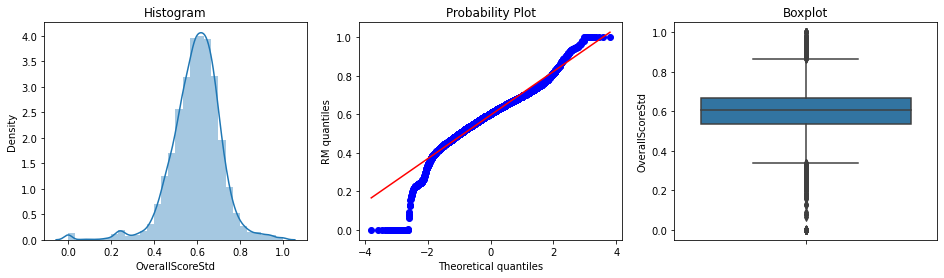

In [7]:
# Outlier distribution of target variable
diagnostic_plots(mlr_df, 'OverallScoreStd')

Lower limit        Upper limit
0.2479692061170607 0.9448749393116329


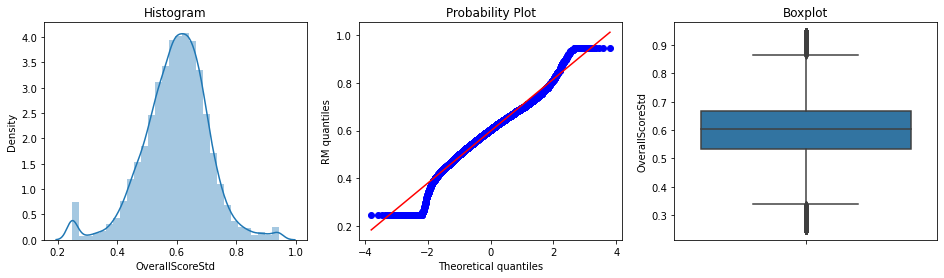

In [8]:
# Add upper and lower range values to variables, to eliminate OverallScoreStd outliers
OverallScoreStd_upper_limit, OverallScoreStd_lower_limit = find_normal_boundaries(mlr_df, 'OverallScoreStd', 3)
print("Lower limit        Upper limit")
print(OverallScoreStd_lower_limit, OverallScoreStd_upper_limit)

# add new columns to dataframe to hold results
mlr_df['OverallScoreStd_lower_limit'] = OverallScoreStd_lower_limit
mlr_df['OverallScoreStd_upper_limit'] = OverallScoreStd_upper_limit

# Apply values to OverallScoreStd
mlr_df['OverallScoreStd'] = np.where(mlr_df['OverallScoreStd'] > OverallScoreStd_upper_limit, OverallScoreStd_upper_limit,
                             np.where(mlr_df['OverallScoreStd'] < OverallScoreStd_lower_limit, OverallScoreStd_lower_limit
                             , mlr_df['OverallScoreStd']))

# Drop columns
mlr_df = mlr_df.drop(['OverallScoreStd_lower_limit', 'OverallScoreStd_upper_limit'], axis=1)

# Show outlier distribution after applying changes
diagnostic_plots(mlr_df, 'OverallScoreStd')

In [9]:
X = mlr_df.loc[ : , mlr_df.columns != 'OverallScoreStd']
y = mlr_df[['OverallScoreStd']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(" X_train    y_train    X_test    y_test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

 X_train    y_train    X_test    y_test
(6622, 7) (6622, 1) (2838, 7) (2838, 1)


In [10]:
# Add constant
X = sm.add_constant(X)

# Run the model
mlr_model = sm.OLS(y, X).fit()

# View the model's summary
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        OverallScoreStd   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2778.
Date:                Wed, 23 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:57:16   Log-Likelihood:                 12739.
No. Observations:                9460   AIC:                        -2.546e+04
Df Residuals:                    9452   BIC:                        -2.541e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3143      0.003    114.109      0.000       0.309       0.320
School_deID           0.0016      0.000      6.846      0.000       0.001       0.002
GradeLevel            0.0135      0.000     33.552      0.000       0.013       0.014
Special_Education    -0.0114      0.002     -5.712      0.000      -0.015      -0.007
OverallLevel          0.0873      0.001    126.443      0.000       0.086       0.089
TeacherGender        -0.0101      0.002     -4.463      0.000      -0.015      -0.006
TeacherEthnicity      0.0015      0.000      4.699      0.000       0.001       0.002
TestInstance          0.0075      0.001     11.446      0.000       0.006       0.009
==============================================================================
Omnibus:                      613.720   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2294.561
Skew:                          -0.235   Prob(JB):                         0.00
Kurtosis:                       5.366   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Multiple Linear Regression - Coefficient observations:
67.3% of the time...

* The school a student attends has the potential to affect an OverallScoreStd by as much as 1.8% and as little as less than 1%

* A student's grade level has the potential to affect an OverallScoreStd by as much as 8% and as little as 1%

* Special_Education = yes, has the potential to affect OverallScoreStd by negative 2%

* Each OverallLevel (1 to 4) carries the weight of nearly 10%

* Male Teachers can reduce a student's OverallScoreStd by 1% versus Female Teachers ( consider there is a bias in Female vs Male Teacher totals)

* TeacherEthnicity has the potential to affect an OverallScoreStd by as little as .001% and as much as  1% (1-7). Consider bias here as Hispanic (value = 3, 5,387 total) and White (value = 7, 3,137 total) are the top representations amongst 7 ethnicities.

* Each new TestInstance has the potential to affect an OverallScoreStd by 1% or as much as 4%

### Logistic Regression

<AxesSubplot:>

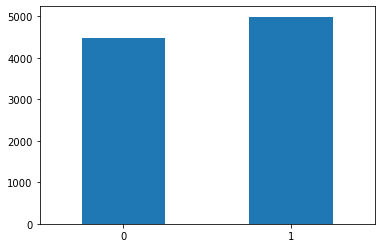

In [11]:
# Copy from main dataframe
lr_df = df.copy()

# Split OverallLevel in half, creating new feature to use as Target
lr_df['OverallLevelSplit'] = np.where(lr_df.OverallLevel == 1, 0, np.where(lr_df.OverallLevel == 2, 0, 1))

# Drop OverallLevel column
lr_df = lr_df.drop('OverallLevel', axis=1)

# Display the new target feature's balance
lr_df.OverallLevelSplit.value_counts().sort_index().plot(kind='bar', rot=0)

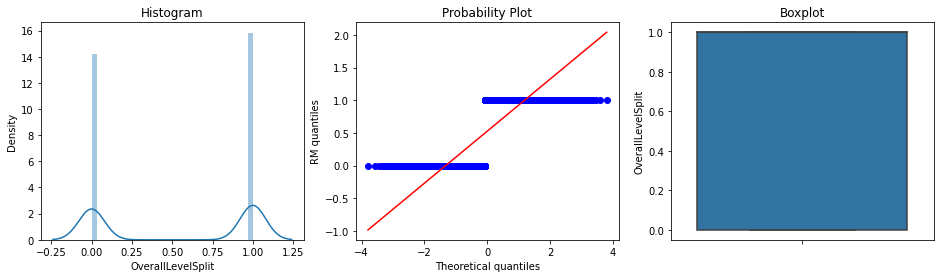

In [12]:
# No outliers
diagnostic_plots(lr_df, 'OverallLevelSplit')

In [13]:
# Drop columns whose p value is too high after viewing summary for OverallLevelSplit
lr_df.drop(lr_df.columns[[13, 10, 17, 6, 2, 9, 3, 11, 7, 5, 15, 8, 1, 0]], axis=1, inplace=True) # .45 R-Squared
lr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Special_Education           9460 non-null   int64  
 1   GradeAttendedPct            9460 non-null   float64
 2   TeacherTotalYearsOfService  9460 non-null   int64  
 3   OverallScoreStd             9460 non-null   float64
 4   TestInstance                9460 non-null   int64  
 5   Growth                      9460 non-null   int64  
 6   OverallLevelSplit           9460 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 517.5 KB


In [14]:
# Correlation for dummy variables for Overall Score
cor = pd.DataFrame(lr_df.corrwith(lr_df['OverallLevelSplit']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallLevelSplit,1.000000
OverallScoreStd,0.624314
Growth,0.334978
GradeAttendedPct,0.005508
TestInstance,-0.001480
TeacherTotalYearsOfService,-0.060857
Special_Education,-0.211801


In [15]:
X_lr = lr_df.loc[ : , lr_df.columns != 'OverallLevelSplit']
y_lr = lr_df[['OverallLevelSplit']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(" X_train    y_train    X_test    y_test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

 X_train    y_train    X_test    y_test
(6622, 8) (6622, 1) (2838, 8) (2838, 1)


In [16]:
# Add constant
X_lr = sm.add_constant(X_lr)

# Run the model
lr_model = sm.OLS(y_lr, X_lr).fit()

# View the model's summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      OverallLevelSplit   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     1290.
Date:                Wed, 23 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:57:17   Log-Likelihood:                -4021.4
No. Observations:                9460   AIC:                             8057.
Df Residuals:                    9453   BIC:                             8107.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.7882      0.023    -35.008      0.000      -0.832      -0.744
Special_Education             -0.1183      0.012    -10.071      0.000      -0.141      -0.095
GradeAttendedPct              -0.0256      0.002    -10.796      0.000      -0.030      -0.021
TeacherTotalYearsOfService    -0.0024      0.000     -5.411      0.000      -0.003      -0.002
OverallScoreStd                2.5452      0.036     70.428      0.000       2.474       2.616
TestInstance                  -0.0310      0.004     -7.891      0.000      -0.039      -0.023
Growth                         0.1292      0.006     23.050      0.000       0.118       0.140
==============================================================================
Omnibus:                     2491.427   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.141
Skew:                          -0.002   Prob(JB):                     7.13e-91
Kurtosis:                       1.974   Cond. No.                         186.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Logistic Regression - Coefficient observations:
45% of the time...

Along with the constant, there are four additional features with negative coefficient values. High values in any of these will result in a lower OverallLevelSplit value:
1. Special_Education
2. GradeAttendedPct
3. TeacherTotalYearsOfService
4. TestInstance

Positive coefficient features are:
1. OverallScoreStd
2. Growth

### K Nearest Neighbor

In [17]:
# Copy from main dataframe
knn_df = df.copy()

In [18]:
X = knn_df.loc[ : , knn_df.columns != 'OverallLevel']
y = knn_df[['OverallLevel']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(" X_train    y_train    X_test    y_test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

 X_train    y_train    X_test    y_test
(6622, 20) (6622, 1) (2838, 20) (2838, 1)


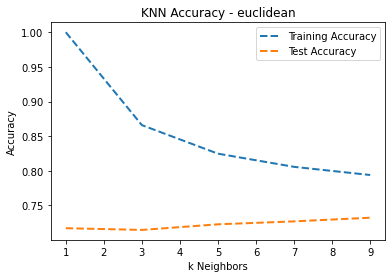

metric: euclidean


k values,Training Accuracy,Test Accuracy
1,1.000000,0.717054
3,0.865902,0.714588
5,0.824675,0.722692
7,0.805648,0.726920
9,0.793869,0.732206


In [19]:
metric='euclidean'
knn_accuracy = []

for i in range(1, 10, 2):
    knn_clsf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(X_train, y_train)

    knn_clsf_train_pred = knn_clsf.predict(X_train)
    knn_clsf_test_pred  = knn_clsf.predict(X_test)

    knn_accuracy.append({'k values': i,
                         'Training Accuracy': accuracy_score(knn_clsf_train_pred, y_train),
                         'Test Accuracy': accuracy_score(knn_clsf_test_pred, y_test)})

# Plot
print("\n")
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Training Accuracy'], '--', linewidth=2, label='Training Accuracy')
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - ' + metric)
plt.legend()
plt.show()

# Results
print("metric:", metric)
pd.DataFrame(knn_accuracy).style.hide_index()

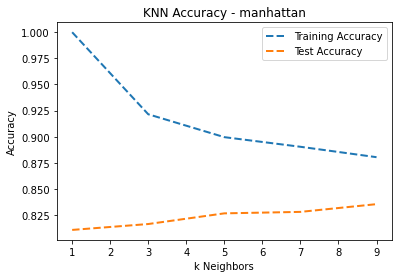

metric: manhattan


k values,Training Accuracy,Test Accuracy
1,1.000000,0.810782
3,0.921474,0.816420
5,0.899577,0.826638
7,0.890365,0.828048
9,0.880399,0.835447


In [20]:
metric='manhattan'
knn_accuracy = []

for i in range(1, 10, 2):
    knn_clsf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(X_train, y_train)

    knn_clsf_train_pred = knn_clsf.predict(X_train)
    knn_clsf_test_pred  = knn_clsf.predict(X_test)

    knn_accuracy.append({'k values': i,
                         'Training Accuracy': accuracy_score(knn_clsf_train_pred, y_train),
                         'Test Accuracy': accuracy_score(knn_clsf_test_pred, y_test)})

# Plot
print("\n")
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Training Accuracy'], '--', linewidth=2, label='Training Accuracy')
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - ' + metric)
plt.legend()
plt.show()

# Results
print("metric:", metric)
pd.DataFrame(knn_accuracy).style.hide_index()

Metric: Manhattan
Neighbors: 5
Train Accuracy: 89.96%
Test Accuracy:  82.66%


              precision    recall  f1-score   support

           1       0.93      0.79      0.86       517
           2       0.77      0.86      0.81       830
           3       0.82      0.84      0.83      1026
           4       0.88      0.77      0.82       465

    accuracy                           0.83      2838
   macro avg       0.85      0.82      0.83      2838
weighted avg       0.83      0.83      0.83      2838



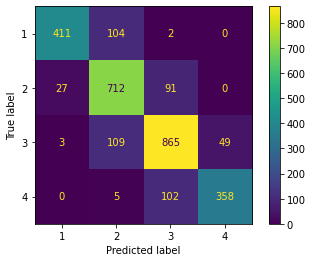

In [21]:
knn_classifier = KNeighborsClassifier(metric='manhattan', n_neighbors=5)

knn_classifier.fit(X_train, y_train)

knn_test_pred = knn_classifier.predict(X_test)
knn_train_pred = knn_classifier.predict(X_train)

print('''Metric: Manhattan
Neighbors: 5''')
print('Train Accuracy:', str(round(accuracy_score(y_train, knn_train_pred)*100,2))+ '%')
print('Test Accuracy: ', str(round(accuracy_score(y_test, knn_test_pred)*100,2))+ '%')
print("\n")
print(classification_report(y_test,knn_test_pred))

knn_cm=knn_classifier.fit(X_train,y_train)
plot_confusion_matrix(knn_cm,X_test,y_test)
plt.show(block=False)

### Decision Tree for Regression

In [96]:
# Copy from main dataframe
dt_df = df.copy()

In [97]:
X = dt_df.loc[ : , dt_df.columns != 'OverallLevel']
y = dt_df[['OverallLevel']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(" X_train    y_train    X_test    y_test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

 X_train    y_train    X_test    y_test
(6622, 20) (6622, 1) (2838, 20) (2838, 1)


|--- OverallScoreStd <= 0.63
|   |--- OverallScoreStd <= 0.55
|   |   |--- GradeAttendedPct <= 1.25
|   |   |   |--- OverallScore <= 1421.50
|   |   |   |   |--- OverallScoreStd <= 0.41
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OverallScoreStd >  0.41
|   |   |   |   |   |--- class: 2
|   |   |   |--- OverallScore >  1421.50
|   |   |   |   |--- OverallScoreStd <= 0.54
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- OverallScoreStd >  0.54
|   |   |   |   |   |--- class: 3
|   |   |--- GradeAttendedPct >  1.25
|   |   |   |--- OverallScore <= 1423.50
|   |   |   |   |--- OverallScore <= 1422.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OverallScore >  1422.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- OverallScore >  1423.50
|   |   |   |   |--- GradeLevel <= 2.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- GradeLevel >  2.50
|   |   |   |   |   |--- class: 1
|   |--- OverallScoreStd >  0.55
|   |   |--- GradeAttendedPct <= 1.31
|   |

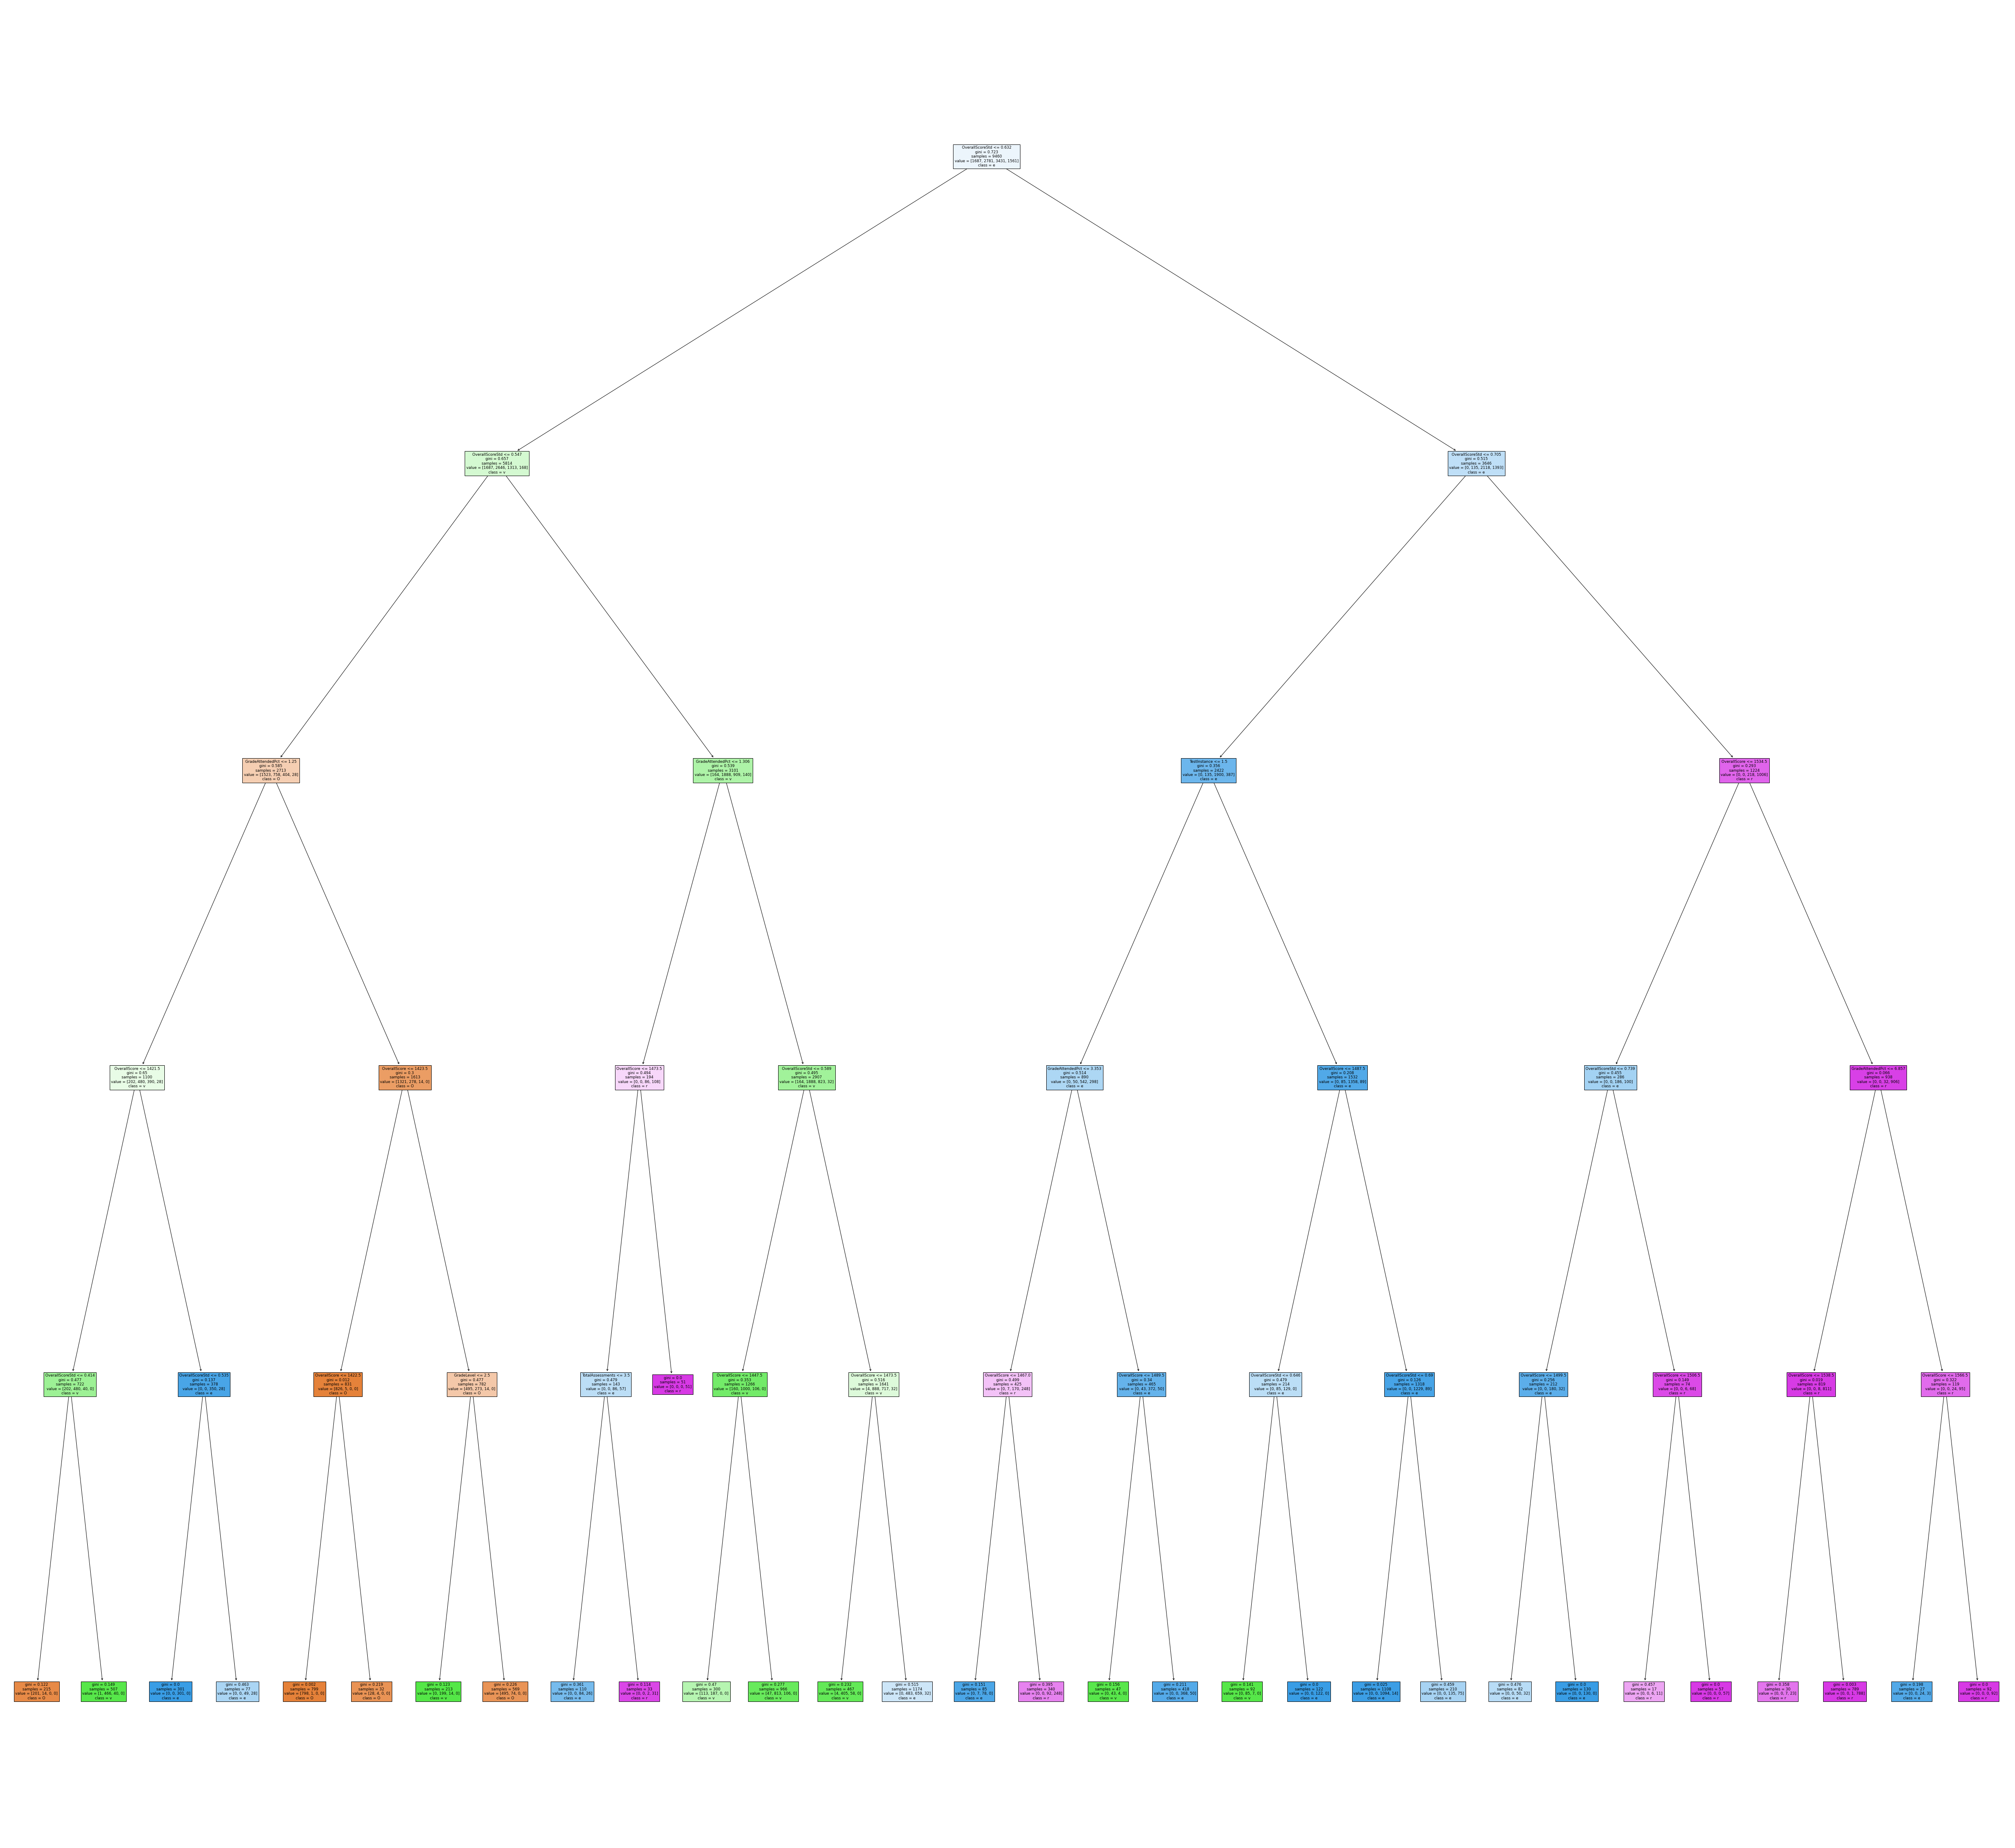

In [98]:
dtc_clf = DecisionTreeClassifier(criterion="gini",max_depth=5).fit(X,y)
fig = plt.figure(figsize=(85,80))

print(tree.export_text(dtc_clf,feature_names=list(X)))

tree.plot_tree(dtc_clf,
               feature_names=list(X),
               class_names='OverallLevel',
               filled=True)

plt.show()

Train Accuracy: 85.91%
Test Accuracy:  85.48%


              precision    recall  f1-score   support

           1       0.95      0.88      0.92       517
           2       0.84      0.79      0.81       830
           3       0.80      0.90      0.85      1026
           4       0.92      0.84      0.88       465

    accuracy                           0.85      2838
   macro avg       0.88      0.85      0.86      2838
weighted avg       0.86      0.85      0.86      2838



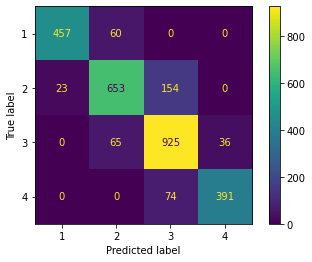

In [99]:
dtc_test_pred = dtc_clf.predict(X_test)
dtc_train_pred = dtc_clf.predict(X_train)

print('Train Accuracy:', str(round(accuracy_score(y_train, dtc_train_pred)*100,2))+ '%')
print('Test Accuracy: ', str(round(accuracy_score(y_test, dtc_test_pred)*100,2))+ '%')
print("\n")
print(classification_report(y_test,dtc_test_pred))

dtc_pred = dtc_clf.predict(X)
plot_confusion_matrix(dtc_clf,X_test,y_test)
plt.show(block=False)